## Spectral Clustering

```{figure} /images/clustering/facebook.jpg
---
height: 300px
name: Social Graph 
align: center
---
Graph clustering is relevant for example in social relation analysis
```
In many real-world scenarios, data is best described not as a list of independent examples, but as a network of relationships. A prominent example arises in social networks, where users are connected based on interactions, friendships, or shared interests. Imagine analyzing user interactions on platforms like Instagram or LinkedIn, where individuals follow each other, like posts, or exchange messages. These interactions can be naturally represented as a graph: nodes correspond to users, and edges indicate some form of connection or similarity.     

A common goal in analyzing such graphs is to identify communities — tightly connected groups of users that likely share common interests or roles. This task is known as graph clustering, and it helps uncover the hidden structure of the network. For instance, in a professional network like LinkedIn, clustering might reveal groups of people working in the same industry or region. On Instagram, it could identify clusters of users centered around specific topics, such as memes, politics, or influencers.      

Unlike traditional clustering methods that operate on vector data, graph clustering works directly with the connectivity information. One powerful approach is spectral clustering, which uses the graph's Laplacian matrix to map nodes into a geometric space where standard clustering algorithms like k-means can be applied. In a way, spectral clustering extends the idea of kernel k-means to more general applications of similarity matrices (that are not necessarily a kernel matrix), while making the algorithm more efficient and robust.
### Similarity Graph Construction
If we are not given a graph directly, we need to construct a similarity graph that captures how similar or related different data points are. This is done by defining a similarity matrix $W\in\mathbb{R}^{n\times n}$, where each entry $W_{ij}$ indicates the similarity between data points $i$ and $j$.

There are several common ways to define this similarity.
#### Epsilon-Neighborhood Graph
The $\epsilon$-neighborhood graph connects two points if their distance is below the threshold $\epsilon$:
$$W_{ij}= \begin{cases}1& \text{if } \lVert D_{i\cdot}-D_{j\cdot}\rVert<\epsilon\\
0& \text{otherwise}\end{cases}$$
This results in an unweighted graph that captures local neighborhoods. It's simple, but sensitive to the choice of $\epsilon$: too small, and the graph may become disconnected; too large, and it may lose local structure. The plot below shows the $\epsilon$-neighborhood graph on the two-circles dataset.

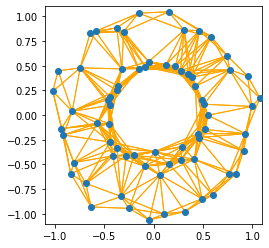

In [1]:
from scipy import sparse
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=0.05)
from sklearn.neighbors import radius_neighbors_graph
sA = radius_neighbors_graph(D, 0.5, mode='connectivity',include_self=False)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

Although the hyperparameter $\epsilon$ is chosen well in this example, we can observe one of the drawbacks of the $\epsilon$-neighborhood graph: it doesn't deal well with data that hasvarying levels of similarities. The points in the inner circle are in tendency closer to each other than the points on the outer circle. Correspondingly, the inner circle points are connected by many edges, but the outer circle points are not. 

#### k-Nearest Neighbor Graph
Alternatively, we can connect each point to its $k$ nearest neighbors. Since this may result in an asymmetric matrix, we symmetrize it:
$$N_{ij}= \begin{cases}1& \text{if } D_{i\cdot} \in KNN(D_{j\cdot})\\
0& \text{otherwise}\end{cases},\quad W=\frac12(N+N^\top)$$
This method ensures that each point is connected to at least $k$ neighbors, and the resulting graph reflects local density. The plot below shows the 6-nearest neighbor graph for the two circles dataset

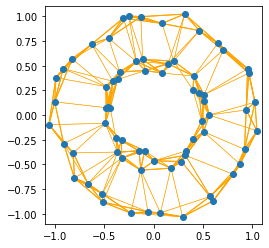

In [2]:
from scipy import sparse
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
epsilon=0.05
D, labels = datasets.make_circles(n_samples=70, factor=.5, noise=epsilon)
from sklearn.neighbors import kneighbors_graph

sA = kneighbors_graph(D, 6, mode='connectivity', include_self=False)
sA = 0.5*(sA+sA.T)
#A=np.exp(-8*(np.sum(D**2,1).reshape(-1,1)  - 2* D@D.T + np.sum(D.T**2,0)))
#A = A/ np.max(A)
#A *= np.tri(*A.shape)
#A*= (A>0.08)
#A=A[A>0.08]
#sA = sparse.csr_matrix(A)
segments = np.concatenate([D[sA.nonzero()[0],:].reshape(-1, 1, 2),D[sA.nonzero()[1],:].reshape(-1, 1, 2)],axis=1)
lc = LineCollection(segments, linewidths=np.array(sA[sA.nonzero()])[0],color='orange')
fig,ax = plt.subplots()

ax.add_collection(lc)
ax.scatter(D[:, 0], D[:, 1],  zorder=10)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal")

We see that the $k$NN graph can deal with the varying cluster densities better than the $\epsilon$-neighborhood graph: the inner and the outer circle are strongly connected. The intuitive idea for this behavior is that the really close neighbors are more likely found within a point's cluster than in another cluster.  

### Formal Objective Definitions
Once we have a similarity matrix WW that encodes the strength of connections between nodes, we can define what it means to find "good" clusters in the graph. There are two common objectives for graph clustering. We will discuss them on the basis of an example graph given by the similarity matrix (weighted adjacency matrix)
\begin{align*}
W = \begin{pmatrix}
0 & 6 & 0 & 0 & 5 & 0\\
6 & 0 & 1 & 0 & 7 & 0\\
0 & 1 & 0 & 9 & 8 & 2\\
0 & 0 & 9 & 0 & 4 & 3\\
5 & 7 & 8 & 4 & 0 & 0\\
0 & 0 & 2 & 3 & 0 & 0
\end{pmatrix}.
\end{align*}
The weighted adjacency matrix indicates a graph that looks as follows:
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};

   \foreach \i/\j/\t in {1/2/1, 2/3/2, 3/4/3, 4/5/4, 5/6/5, 6/1/6, 5/1/7, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
#### Maximum Similarity Within Clusters
One approach is to group nodes such that the total similarity within each cluster is maximized. Let $Y\in\mathbb{R}^{n\times r}$ be a cluster indicator matrix, where each row indicates the cluster membership of a data point (exactly one nonzero entry per row). Then, the similarity within cluster $s$ is computed by summing up all edge weights for nodes in cluster $\mathcal{C}_{s}$, indicated by $Y_{\cdot s}$: 
\begin{align*}
\frac{1}{\lvert \mathcal{C}_{s}\rvert}\sum_{i,j\in\mathcal{C}_s} W_{ji}
= \frac{Y_{\cdot s}^\top W Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}.
\end{align*}
Summing over all clusters gives the total within-cluster similarity:
\begin{align*}
Sim(Y;W)&=\tr(Y^\top W Y(Y^\top Y)^{-1})\\
&=\sum_{s=1}^r\frac{Y_{\cdot s}^\top W Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
=\sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_{s}\rvert}\sum_{i,j\in\mathcal{C}_s} W_{ji}
\end{align*}
The maximum similarity graph clustering problem is then given as follows.
`````{admonition} Task (Maximum Similarity Graph Clustering)
:class: tip
**Given** a graph indicated by a symmetric, nonnegative similarity matrix $W\in\mathbb{R}_+^{n\times n}$, and the number of clusters $r$.     
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ which maximize the similarity of points within a cluster
\begin{align*}
 \max_Y\ Sim(Y;W)&=\tr(Y^\top W Y(Y^\top Y)^{-1}) &\text{s.t. } Y\in\mathbb{1}^{n\times r}
\end{align*}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
`````
````{prf:example}
We compute the similarity within the cluster  $Y_{\cdot s}=(1, 1, 0, 0, 1, 0)$:
\begin{align*}
\frac{Y_{\cdot s}^\top WY_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
&= \frac{2(5+6+7)}{3} = 12
\end{align*}
The graph below visualizes the points belonging to cluster $Y_{\cdot s}$ with the red nodes. We see how the similarity is computed by summing up the edges connecting nodes in this cluster: 5,6, and 7. Those edge weights are added twice, because we have an undirected graph, and every edge is counted once from point $i$ to $j$, and once from point $j$ to $i$.   

```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
    {\ifnum \x>0
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \else
     \node [circle,draw=magenta,fill=magenta!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \fi};

   \foreach \i/\j/\t in {5/6/5, 6/1/6, 5/1/7}
    \draw [draw=magenta, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
   
   \foreach \i/\j/\t in {4/5/4, 1/2/1, 2/3/2, 3/4/3, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
````
#### Minimum Cut Between Clusters
An alternative is to minimize the cut, which measures how strongly clusters are connected to the rest of the graph. For a given cluster $\mathcal{C}_s$, the cut for this cluster sums up all the weight edges that would be cut if we cut out cluster $s$ from the graph:
\begin{align*}
\frac{1}{\lvert \mathcal{C}_s\rvert}\sum_{i\notin\mathcal{C}_s}\sum_{j\in\mathcal{C}_s}W_{ij} = \frac{(\vvec{1}-Y_{\cdot s})^\top WY_{\cdot s}}{\lvert Y_{\cdot s}\rvert}
\end{align*}
The total cut value of a clustering sums up all the weights that would be cut if we cut all clusters out of the graph:
\begin{align*}
Cut(Y;W)&=\tr((\vvec{1}-Y)^\top W Y(Y^\top Y)^{-1}) \\
&= \sum_{s=1}^r\frac{(\vvec{1}-Y_{\cdot s})^\top WY_{\cdot s}}{\lvert Y_{\cdot s}\rvert} 
= \sum_{s=1}^r\frac{1}{\lvert \mathcal{C}_s\rvert}\sum_{i\notin\mathcal{C}_s}\sum_{j\in\mathcal{C}_s}W_{ij}
\end{align*}
The minimum cut graph clustering problem is then:
`````{admonition} Task (Minimum Cut Graph Clustering)
:class: tip
**Given** a graph indicated by a symmetric, nonnegative similarity matrix $W\in\mathbb{R}_+^{n\times n}$, and the number of clusters $r$.     
**Find** clusters indicated by the matrix $Y\in\mathbb{1}^{n\times r}$ which minimize the cut of all clusters
\begin{align*}
 \min_Y\ Cut(Y;W)&=\tr((\vvec{1}-Y)^\top W Y(Y^\top Y)^{-1}) &\text{s.t. } Y\in\mathbb{1}^{n\times r}
\end{align*}
**Return** the clustering $Y\in\mathbb{1}^{n\times r}$
`````
````{prf:example}
We compute the cut of cluster $Y_{\cdot s}=(1, 1, 0, 0, 1, 0)$
\begin{align*}
\frac{Y_{\cdot s}^\top W (\vvec{1}-Y_{\cdot s})}{\lvert Y_{\cdot s}\rvert}
&= \frac{2(1+8+4)}{3}=8\frac{2}{3}
\end{align*}
The graph below visualizes the nodes of the cluster and the edges that would have to be cut when we cut out cluster $Y_{\cdot s}$. Note that we count every edge weight twice again, since we cut strictly speaking an edge from point $i$ to $j$ and also the edge from $j$ to $i$.
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
    {\ifnum \x>0
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \else
     \node [circle,draw=magenta,fill=magenta!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};
    \fi};

   \foreach \i/\j/\t in {1/2/1, 5/2/8, 4/5/4}
    \draw [draw=magenta, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
   
   \foreach \i/\j/\t in {5/6/5, 6/1/6, 5/1/7, 2/3/2, 3/4/3, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
````

### Optimization
The maximum similarity and minimum cut formulations give us clear goals for clustering a graph, but solving them directly is difficult due to the discrete nature of the cluster indicator matrix $Y$. Spectral clustering uses the same trick as kernel k-means to optimize the trace objective. This seems probably straightforward for the maximum similarity objective, but not so much for the minimum cut objective.
#### The Graph Laplacian
````{prf:definition} Degree Matrix and Graph Laplacian
Given a graph indicated by a weighted adjacency matrix $W\in\mathbb{R}_+^{n\times n}$.      
The **degree matrix** is the diagonal matrix having the sum of all connecting edges for each node on the diagonal: $$I_W = \mathrm{diag}\left(\sum_{i=1}^n W_{1i},\ldots,\sum_{i=1}^n W_{ni}\right).$$     
The **unnormalized graph Laplacian**, also called **difference Laplacian** is the matrix $$L=W-I_W.$$
````
In practice, the weighted adjacency matrix is often normalized. The corresponding Graph Laplacian is often denoted by
$$ L_{sym}= I-I_W^{-1/2}WI_W^{-1/2}.$$
All of the following results can be shown for the symmetrically normalized graph Laplacian as well. 
````{prf:example}
We compute the degree matrix and the graph Laplacian for our example graph
```{tikz}
\begin{tikzpicture}[shorten >=1pt, auto, node distance=3cm, ultra thick,
   edge_style/.style={draw=blue}]

   \foreach [count=\i] \x/\y/\t in {-2/2/2, 2/2/3, 4/0/6, 2/-2/4, -2/-2/5, -4/0/1}
     \node [circle,draw=blue,fill=blue!20!,font=\sffamily\Large\bfseries]
        (v\i) at (\x,\y) {\t};

   \foreach \i/\j/\t in {1/2/1, 2/3/2, 3/4/3, 4/5/4, 5/6/5, 6/1/6, 5/1/7, 5/2/8, 4/2/9}
    \draw [edge_style, line width = 0.2*\t]  (v\i) edge node{\t} (v\j);
\end{tikzpicture}
```
$$I_W = 
\begin{pmatrix}
    11 & 0 & 0 & 0 & 0 & 0\\
    0 & 14 & 0 & 0 & 0 & 0\\
    0 & 0 & 20 & 0 & 0 & 0\\
    0 & 0 & 0 & 16 & 0 & 0\\
    0 & 0 & 0 & 0 & 24 & 0\\
    0 & 0 & 0 & 0 & 0 & 5
\end{pmatrix}$$
\begin{align*}
L = \begin{pmatrix}
11 & -6 & 0 & 0 & -5 & 0\\
-6 & 14 & -1 & 0 & -7 & 0\\
0 & -1 & 20 & -9 & -8 & -2\\
0 & 0  & -9 & 16 & -4 & -3\\
-5& -7 & -8 & -4 & 24 & 0\\
0 & 0 & -2 & -3 & 0 & 5
\end{pmatrix}.
\end{align*}
````
```{prf:lemma} Positive Definiteness of Laplacians
Given a symmetric similarity matrix $W\in\mathbb{R}^{n\times n}_+$, the Laplacian $L=I_W -W$ is positive semi-definite.
```
````{toggle}
```{prf:proof}
Let $0\neq v\in\mathbb{R}^n$, then
\begin{align*}
v^\top Lv &= v^\top I_W v - v^\top W v 
= \sum_{i=1}^n v_i^2 \lvert W_{i\cdot}\rvert -\sum_{1\leq i,j\leq n} v_iv_jW_{ij}\\
&= \frac{1}{2} \sum_{1\leq i,j \leq n} (v_i^2 W_{ij} -2 v_iv_jW_{ij} +v_j^2W_{ij}) \\
&= \frac{1}{2} \sum_{1\leq i,j \leq n} W_{ij} (v_i-v_j)^2 \geq 0.
\end{align*}
```
````
The positive definiteness of the Laplacian means in particular that all eigenvalues of the graph Laplacian are positive. The smallest eigenvalue of the graph Laplacian is zero, and it has a specific relationship to the graph.
```{prf:theorem} Connected Components and Eigenvectors
Given a graph indicated by the symmetric matrix $W\in\mathbb{R}^{n\times n}_+$, then the indicator vectors of the connected components are eigenvectors of the Laplacian $L=I_W-W$ to the smallest eigenvalue $0$.   
```
````{toggle}
```{prf:proof}
For every connected component there exists an order of columns and rows such that $W$ has a block-diagonal form:
\begin{align} 
Wv = 
\left(
\begin{array}{c:r}
\begin{matrix}
 W_{11}&\ldots&W_{1c}  \\
 \vdots&&\vdots \\
 W_{c1}&\ldots&W_{cc} \\
\end{matrix}
& \mathbf{0}\\
\mathbf{0} & \widehat{W} \\
\end{array}
\right)
\begin{pmatrix}
 1\\
 \vdots\\
 1 \\
 \mathbf{0} 
\end{pmatrix}
=
\begin{pmatrix}
 \lvert W_{1\cdot}\rvert\\
 \vdots\\
 \lvert W_{c\cdot}\rvert \\
 \mathbf{0} 
\end{pmatrix}
=I_Wv.
\end{align}
```
````
The indication of connected components by the first eigenvector(s) of the negative graph Laplacian creates a bridge from the spectrum of the graph Laplacian to the clustering objective. For any binary cluster indicator matrix $Y_{\cdot s}$ the similarity of points within that cluster are at most the sum of all the degrees of nodes in that cluster: $$Y_{\cdot s}^\top WY_{\cdot s}\leq Y_{\cdot s}I_WY_{\cdot s} .$$
We have equality $Y_{\cdot s}^\top WY_{\cdot s}=Y_{\cdot s}^\top I_WY_{\cdot s}$ **if and only if** $Y_{\cdot s}$ indicates a connected component. This is equivalent to 
$$Y_{\cdot s}^\top \underbrace{(I_W - W)}_{=L}Y_{\cdot s }=0.$$
This suggests that connected components are optimal clusters: they incur zero cut cost and hence minimize the minimum cut objective. However, in practice, we rarely want to recover exact connected components. Real-world graphs are often noisy, or constructed using heuristics and hyperparameters (like radius or number of neighbors). A single misplaced or missing edge can split or merge components. Therefore, connected components are typically not reliable indicators of meaningful clusters.      

To overcome this, we assume the graph has only one connected component (or is artificially connected using small edge weights), so that we can go beyond trivial solutions and focus on uncovering meaningful cluster structure.     

Spectral clustering is commonly introduced as a relaxation of the minimum cut objective. Instead of recovering the first eigenvectors of $−L$, which correspond to connected components, it uses the next $r$ eigenvectors (those with the smallest non-zero eigenvalues). These eigenvectors form a continuous embedding of the data. k-means is then applied to this embedding to discretize the solution and obtain clusters. However, this interpretation only tells half the story. In this narrative, it's not clear why k-means is used for the discretization of eigenvectors. This makes sense however, when we derive the equivalence of graph clustering approaches to kernel k-means. 
#### Relationship to Kernel k-means
First, we observe that the minimum cut and the maximum similarity objective are equivalent for specific choices of the adjacency matrix:
```{prf:theorem} Minimum Cut and Maximum Similarity Equivalences 
Given a symmetric similarity matrix $W\in\mathbb{R}^{n\times n}_+$, the degree matrix $I_W$ and the Graph Laplacian $L=I_W-W$, then the following objectives are equivalent:
\begin{align*}
    \min_YCut(Y;W)  &= \tr((\vvec{1}-Y)^\top WY(Y^\top Y)^{-1}) &\text{ s.t }Y\in\mathbb{1}^{n\times r} \\
    \max_Y Sim(Y;-L) &= \tr(Y^\top (-L) Y(Y^\top Y)^{-1}) &\text{ s.t }Y\in\mathbb{1}^{n\times r}
\end{align*}
```
````{toggle}
```{prf:proof}
Follows from the fact that 
\begin{align*}
\tr(Y^\top I_W Y(Y^\top Y)^{-1}) &= \sum_{s=1}^r\sum_{i=1}^n \frac{Y_{is}\lvert W_{i\cdot}}\rvert}{\lvert Y_{\cdot s}\rvert}\\
&= \sum_{s=1}^r\sum_{i=1}^n \frac{\mathbf{1}^\top W Y_{\cdot s}}{\lvert Y_{\cdot s}\rvert}\\
&= \tr (\mathbf{1}^\top W Y(Y^\top Y)^{-1})
\end{align*}
```
````
The maximum similarity objective is equal to the kernel $k$-means objective. However, note that $-L$ is not a kernel matrix (it's negative semi-definite). But we can make $-L$ into a kernel, that doesn't change the objective.

```{prf:corollary} Graph Clustering and k-means equivalence
Given a symmetric matrix $W\in\mathbb{R}^{n\times n}_+$, having the smallest eigenvalue $\lambda_{min}$. If $\lambda_{min}$ is nonnegative, then the maximum similarity graph clustering objective is equivalent to the kernel k-means objective for $K=W$.      
If $\lambda_{min}$ is negative, then the maximum similarity graph clustering objective is equivalent to the kernel k-means objective with $K=W-\lambda_{min}I$.
```
### Spectral Clustering Algorithm
As a result, we have that the minimum cut objective is equivalent to kernel k-means with the kernel $K=-L-\lambda_{min}I$. That is, we can compute a symmetric factorization of  
$$K=-L-\lambda_{min}I = AA^\top$$ 
and apply k-means on $A$ to obtain the solution. Spectral clustering introduces now two changes to the kernel k-mean method:
1. Use only the eigenvectors $V$ of $K=V\Lambda V^\top$ instead of the scaled eigenvectors $V\Lambda^{1/2}$. This might be due to the fact that the equivalence stated above was not clear when spectral clustering was introduced. The eigendecomposition of $-L=V(\Lambda+\lambda_{min}I)V^\top$ has only negative eigenvalues, which does not allow for the application of the square root. 
2. Use a truncated approximation of $K\approx V_{cdot \mathcal{R}}\Lambda V_{\cdot \mathcal{R}}^\top$ where $\mathcal{R}={2,\ldots, r+1}$ excludes the first eigenvector that indicates the connected component. The truncated eigendecomposition speeds up the process and it allows k-means to focus the clustering search to a subspace that is relevant for clustering.

#### Pseudocode
The pseudocode below details the method of spectral clustering.
```{prf:algorithm} spectral clustering
**Input**: data matrix $D$, number of clusters $r$, similarity matrix $W$      
**Require**: the similarity matrix should indicate a connected graph
1. $L\gets I_W-W$ #*Compute Graph Laplacian - other graph Laplacians are also possible*
2. $(V,\Lambda) \gets$ `TruncatedEigendecomposition`$(L,r+1)$
3. $A\leftarrow V_{\cdot\{2,\ldots, r+1\}}$ #*Remove connected component*
4. $(X,Y)\gets$`kMeans`$(A,r)$
3. **return** $Y$
```
### Application to the Two Circles Dataset
We have a look at the clustering obtained by spectral clustering and the embedding on the two circles dataset. The code below implements spectral clustering for the difference Laplacian. This code is not optimized for efficiency and uses here a full eigendecomposition instead of computing the truncated eigendecomposition directly (which is much faster).

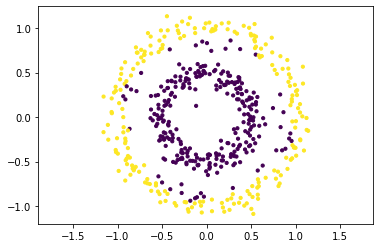

In [3]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

D, labels = datasets.make_circles(n_samples=500, factor=.5, noise=0.08)
W= rbf_kernel(D, D,gamma=0.3)
L= np.diag(np.sum(W,1))-W
lambdas, V = np.linalg.eig(L)
kmeans = KMeans(n_clusters=2,n_init=1)
A = np.abs(V[:,1:3])
kmeans.fit(A)
plt.scatter(D[:, 0], D[:, 1], c=kmeans.labels_, s=10)
plt.axis('equal')
plt.show()

The plots below indicate the ground truth clustering in the original feature space and in the transformed feature space, spanned by the second and third eigenvector of $L$. Note that k-means clustering in the transformed feature space indicates directly the clustering in the original feature space.

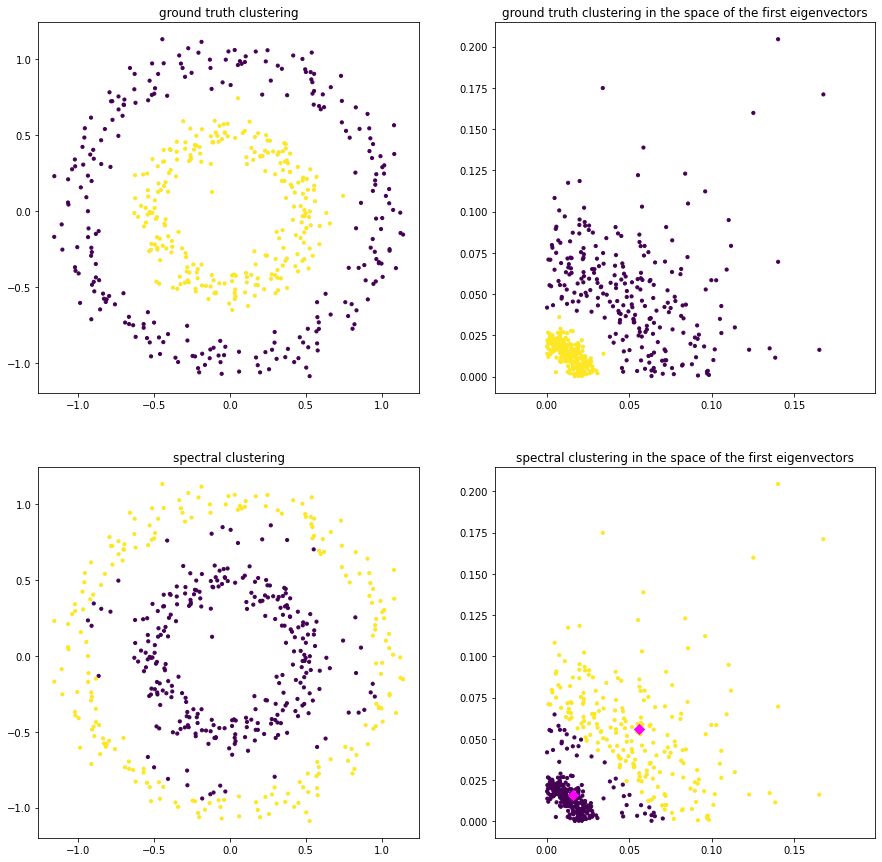

In [4]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, c=labels) 
plt.title("ground truth clustering")
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.scatter(A[:, 0], A[:, 1], s=10, c=labels) 
plt.title("ground truth clustering in the space of the first eigenvectors")
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, c=kmeans.labels_) 
plt.title("spectral clustering")
plt.axis('equal')

plt.subplot(2, 2, 4)
plt.scatter(A[:, 0], A[:, 1], s=10, c=kmeans.labels_) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='magenta', s=50, marker = 'D')
plt.title("spectral clustering in the space of the first eigenvectors")
plt.axis('equal')
plt.show()